# Model: Support Vector Classifier
---

# 1. Setting up the notebook

In [9]:
# import pyforest
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, fbeta_score, roc_auc_score, roc_curve, auc
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_validate, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC

In [10]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

y_train = df_train[["attrition_flag"]]
x_train = df_train.drop("attrition_flag", axis=1)

y_test = df_test[["attrition_flag"]]
x_test = df_test.drop("attrition_flag", axis=1)

# 2. Running base model

In [11]:
def cv_evaluate_model(svc):
    scale_features = x_train.drop("gender", axis=1).columns
    scaler = ColumnTransformer(transformers=[ ('scaler', MinMaxScaler(), scale_features) ], remainder='passthrough')
    pipeline = Pipeline(steps = [['scaler', scaler ],
                                 ['smote', SMOTE(random_state=2021)],
                                 ['classifier', svc]
                                ])

    stratified_kfold = StratifiedKFold(shuffle=True, n_splits=3, random_state=2021)

    scoring = {"accuracy": "accuracy",
               "recall": 'recall',
               "precision": "precision",
               "fbeta_2": make_scorer(fbeta_score, beta=2),
               "roc_auc": make_scorer(roc_auc_score),
              }

    scores = cross_validate(pipeline, x_train, y_train.values.ravel(), cv=stratified_kfold,
                           scoring = scoring)

    accuracy = [ val for val in scores['test_accuracy'] ]
    recall = [ val for val in scores['test_recall'] ]
    precision = [ val for val in scores['test_precision'] ]
    fbeta_2 = [ val for val in scores['test_fbeta_2'] ]
    auc = [ val for val in scores['test_roc_auc'] ]

    accuracy.append( sum(accuracy) / len(accuracy) )
    recall.append( sum(recall) / len(recall) )
    precision.append( sum(precision) / len(precision) )
    fbeta_2.append( sum(fbeta_2) / len(fbeta_2) )
    auc.append( sum(auc) / len(auc) )

    score_df = pd.DataFrame(data=[accuracy, recall, precision, fbeta_2, auc], columns=['Fold 1','Fold 2','Fold 3', 'Average'],
                                index=['Accuracy', 'Recall', 'Precision', 'Fbeta2', 'AUC'])
    return score_df

In [12]:
svc_clf = SVC(random_state = 2021)
base_model = cv_evaluate_model(svc_clf)
display(base_model)

,Fold 1,Fold 2,Fold 3,Average
Accuracy,0.878193,0.885926,0.881852,0.881990
Recall,0.841014,0.850230,0.841014,0.844086
Precision,0.584000,0.602941,0.593496,0.593479
Fbeta2,0.772978,0.785775,0.776265,0.778339
AUC,0.863162,0.871496,0.865344,0.866668


# 3. Hyperparameter Tuning with GridSearchCV

## 3.1 First Grid Search

In [5]:
pipeline = Pipeline([["scaler", MinMaxScaler()],
                     ["smote", SMOTE(random_state = 2021)],
                     ["model", SVC(random_state = 2021)]])

In [6]:
param_grid =  { 'model__C': [0.1, 1, 10, 100, 1000],  
               'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
               'model__kernel': ['rbf','linear','sigmoid']  }

In [7]:
total_combi = 1
for param, value in param_grid.items():
    print(param, value)
    total_combi *= len(value)

print('-----------------')
print('Total combinations:', total_combi)
print('Total combinations across 5-folds:', total_combi*5)

model__C [0.1, 1, 10, 100, 1000]
model__gamma [1, 0.1, 0.01, 0.001, 0.0001]
model__kernel ['rbf', 'linear', 'sigmoid']
-----------------
Total combinations: 75
Total combinations across 5-folds: 375


In [8]:
svc_gridsearch1 = GridSearchCV(pipeline, param_grid, scoring = 'recall', cv = 5, n_jobs = -1, verbose = 1)
svc_gridsearch1.fit(x_train, np.ravel(y_train))
best_params = svc_gridsearch1.best_params_
print("Best Parameters: ", best_params)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best Parameters:  {'model__C': 1000, 'model__gamma': 0.1, 'model__kernel': 'rbf'}


## 3.2 Second Grid Search

#### Best params of First Grid Search
{'model__C': 1000, 'model__gamma': 0.1, 'model__kernel': 'rbf'}

In [10]:
param_grid =  { 'model__C': [100, 1000, 10000],  
               'model__gamma': [1, 0.1, 0.01], 
               'model__kernel': ['rbf']  }

In [11]:
total_combi = 1
for param, value in param_grid.items():
    print(param, value)
    total_combi *= len(value)

print('-----------------')
print('Total combinations:', total_combi)
print('Total combinations across 5-folds:', total_combi*5)

model__C [100, 1000, 10000]
model__gamma [1, 0.1, 0.01]
model__kernel ['rbf']
-----------------
Total combinations: 9
Total combinations across 5-folds: 45


In [12]:
svm_gridsearch2 = GridSearchCV(pipeline, param_grid, scoring = 'recall', cv = 5, n_jobs = -1, verbose = 1)
svm_gridsearch2.fit(x_train, np.ravel(y_train))
best_params = svm_gridsearch2.best_params_
print("Best Parameters: ", best_params)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters:  {'model__C': 1000, 'model__gamma': 0.1, 'model__kernel': 'rbf'}


### Conclusion
Here, we can infer that the best parameters for GridSearchCV 1 and GridSearchCV 2 are the same even after making changes to ```param_grid```. As such, we can conclude that the best parameters after hyperparameter tuning are: <br><br>
```{'model__C': 1000, 'model__gamma': 0.1, 'model__kernel': 'rbf'}```

We will be using these parameters to evaluate our model on the test set, in Section 5.

# 4. Evaluation on Test Set

In [9]:
smote_sampler = SMOTE(random_state=2021)
scale_features = x_train.columns
scaler = ColumnTransformer(transformers=[ ('scaler', MinMaxScaler(), scale_features) ])
svc_final = SVC(C=1000, gamma=0.1, kernel='rbf')

pipeline = Pipeline(steps = [['scaler', scaler],
                             ['smote', smote_sampler],
                             ['classifier', svc_final]])

pipeline.fit(x_train, y_train.values.ravel() )

y_pred = pipeline.predict(x_test)

print("-----------------------PERFORMANCE EVALUATION--------------------  ")
print(f"Recall: {recall_score(y_test, y_pred)} ")
print(f"Fbeta2: {fbeta_score(y_test, y_pred, beta=2)} ")
print(f"AUC Score: {roc_auc_score(y_test, y_pred)} ")

-----------------------PERFORMANCE EVALUATION--------------------  
Recall: 0.8215384615384616 
Fbeta2: 0.7512661789532921 
AUC Score: 0.8490408357075024 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

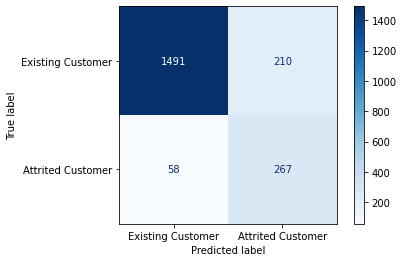

In [10]:
cm = confusion_matrix(y_test, y_pred)
labels = ['Existing Customer', 'Attrited Customer']

diagram = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
diagram.plot(cmap=plt.cm.Blues)
plt.show()